In [47]:

%load_ext autoreload
%autoreload 2

from pl_trainer import LightningModule
from data_module import MNISTDataModule
from torchvision import transforms
import torch.nn as nn
import lightning.pytorch as pl
import pandas as pd
import matplotlib.pyplot as plt
import torch

pl.seed_everything(42)

Seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


42

# Setting up Hyperparameters

In [48]:
lr = 0.02 # Learning rate
batch_size = 64
max_epochs = 5

# Defining Model Architecture 

In [49]:
def create_model():
    """
        Initializes the model. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(),  # Flatten the image from shape (batch_size, C, Height, Width) to (batch_size, 28*28)
        nn.Linear(28*28*1, 64),  # First fully connected layer (input: 784, output: 64 nodes)
        nn.ReLU(),  # ReLU (Rectified Linear Unit) activation function for the hidden layer
        nn.Linear(64, 10),  # Output layer (10 nodes for the 10 classes)
        # No need to include softmax, as it is combined in the loss function
    )
    return model

# Initialize the model, data module, and trainer
pl_model = LightningModule(model = create_model(), lr=lr)

# Setting up Dataloaders and Transformations

In [50]:
import torchvision.transforms as transforms

my_transforms = transforms.Compose([
            transforms.ToTensor(), # Convert image to tensor, normalize, ie from [0, 255] -> [0.0, 1.0]
            transforms.Normalize((0.5,), (0.5,)) # Normalize image with mean 0.5 and standard deviation with 0.5, ie from [0.0, 1.0] -> [(-1.0), 1.0]
        ])

mnist_data = MNISTDataModule(batch_size=batch_size, transforms=my_transforms)

# Train Model

In [51]:
# Initialize CSVLogger
csv_logger = pl.loggers.CSVLogger(save_dir='logs/', name='mnist_logs', version=0)

# Set up the trainer
trainer = pl.Trainer(max_epochs=max_epochs, logger=csv_logger, check_val_every_n_epoch=1, enable_checkpointing=False)

# Train the model
trainer.fit(pl_model, mnist_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Martynas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\fabric\loggers\csv_logs.py:268: Experiment logs directory logs/mnist_logs\version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | Sequential         | 50.9 K | train
1 | loss_fn | CrossEntropyLoss   | 0      | train
2 | acc_fn  | MulticlassAccuracy | 0      | train
-------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


C:\Users\Martynas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\Martynas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 937/937 [00:14<00:00, 65.03it/s, v_num=0, val_acc=0.942, val_loss=0.198]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 937/937 [00:14<00:00, 65.02it/s, v_num=0, val_acc=0.942, val_loss=0.198]


# Plot Results

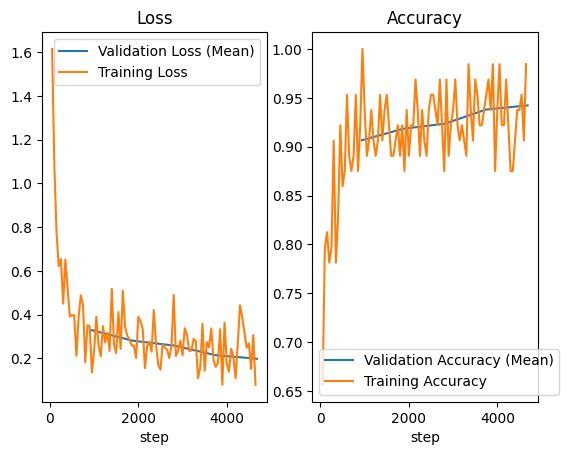

Final validation loss 0.1977
Final validation accuracy 0.9422


In [52]:
df = pd.read_csv('logs/mnist_logs/version_0/metrics.csv')

# Create a figure and axes objects
fig, ax = plt.subplots(1,2)

# Plot 'val_loss' on the axes
df.dropna(subset=['val_loss']).plot(x='step', y='val_loss', ax=ax[0], label='Validation Loss (Mean)')
# Plot 'train_loss' on the same axes
df.dropna(subset=['train_loss']).plot(x='step', y='train_loss', ax=ax[0], label='Training Loss')

# Plot 'val_loss' on the axes
df.dropna(subset=['val_acc']).plot(x='step', y='val_acc', ax=ax[1], label='Validation Accuracy (Mean)')
# Plot 'train_loss' on the same axes
df.dropna(subset=['train_acc']).plot(x='step', y='train_acc', ax=ax[1], label='Training Accuracy')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.show()

print("Final validation loss", round(df['val_loss'].iloc[-1], 4))
print("Final validation accuracy", round(df['val_acc'].iloc[-1], 4))

# Plot weights

Shape of weights: torch.Size([64, 784])


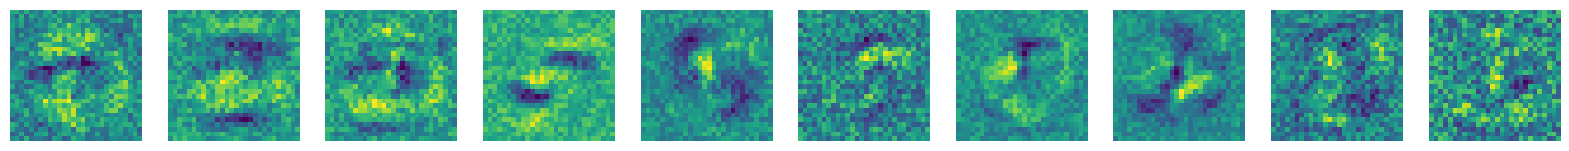

In [53]:
def plot_weights(weights, layer_shape=(28, 28)):
    """
    Plots the weights of the first layer of a multi-layer neural network.
    Assumes the first layer connects to image inputs.
    
    Args:
        weights: The weight matrix from a linear layer (e.g. [64, 784])
        layer_shape: The shape to reshape the weights into (default is 28x28 for MNIST).
    """
    
    # Check if the number of nodes in the layer is more than we can plot. For now, we handle up to 10.
    num_plots = min(10, weights.shape[0])
    
    # Create subplots
    fig, axs = plt.subplots(1, num_plots, figsize=(20, 2))
    
    # Loop through and plot each set of weights
    for i in range(num_plots):
        reshaped_weight = weights[i].view(*layer_shape)  # Reshape weight to 28x28
        axs[i].imshow(reshaped_weight.cpu().numpy(), cmap='viridis')
        axs[i].axis('off')
    
    plt.show()


# Assuming the weights of the first layer connect input images to 64 hidden units
# Example of getting weights for a linear layer (e.g., [64, 784]):
weight = list(pl_model.model.children())[1].state_dict()["weight"].cpu().data

# Shape of the weights, for example (64, 784), connecting 64 hidden units to 28x28 input
print("Shape of weights:", weight.shape)

# Plot the first layer's weights if the shape is valid for input images (like 784 = 28*28)
if weight.shape[1] == 28*28:
    plot_weights(weight)
else:
    print("This function only works for layers that connect to image inputs (like a [hidden_units, 784] layer).")
